In [36]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
!pip install scikit-plot

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [30]:
# Importing necessary libraries
import math
import nltk
import scipy
import string
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from scipy.stats import randint
from wordcloud import WordCloud
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from scipy.stats import loguniform

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold

from IPython.display import display
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 6]
import warnings

warnings.filterwarnings('ignore')

In [31]:
# Load the dataset
df = pd.read_csv('Tweets.csv', header=0)
df.drop(['selected_text', 'textID'], axis=1, inplace=True)
target = 'sentiment'
df.reset_index(drop=True, inplace=True)
original_df = df.copy(deep=True)

In [32]:
# Handling missing values
df.dropna(inplace=True)
original_df = df.copy()

In [33]:
# Removing duplicates
counter = 0
r, c = original_df.shape

df1 = df.drop_duplicates()
df1.reset_index(drop=True, inplace=True)

if df1.shape == (r, c):
    print('\n\033[1mInference:\033[0m The dataset does not contain any duplicates.')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates removed ---> {r - df1.shape[0]}')


Inference: The dataset does not contain any duplicates.


In [34]:
# Preprocessing text
df = df1.copy()

def preprocessor(text):
    text = text.lower()
    text = ''.join([i for i in text if i in string.ascii_lowercase + ' '])
    text = ' '.join([PorterStemmer().stem(word) for word in text.split()])
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

for i in tqdm(range(df.shape[0])):
    df.loc[i, 'text'] = preprocessor(df['text'][i])

100%|██████████| 27480/27480 [01:39<00:00, 276.30it/s]


In [37]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(
    strip_accents=None,
    lowercase=False,
    preprocessor=None,
    tokenizer=nltk.word_tokenize,  # Using NLTK tokenizer
    use_idf=True,
    norm='l2',
    smooth_idf=True
)

y = df[target].values
x = tfidf.fit_transform(df.text)

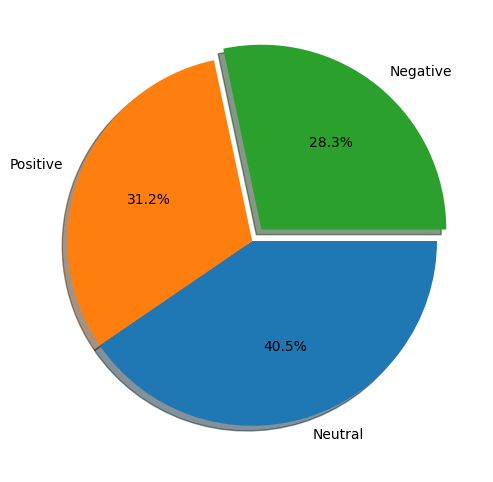

In [38]:
# Data Exploration

# Target Variable Distribution
plt.pie(df[target].value_counts(), labels=['Neutral', 'Positive', 'Negative'], counterclock=False, shadow=True,
        explode=[0, 0, 0.08], autopct='%1.1f%%', radius=1, startangle=0)
plt.show()

100%|██████████| 27480/27480 [00:19<00:00, 1428.18it/s]


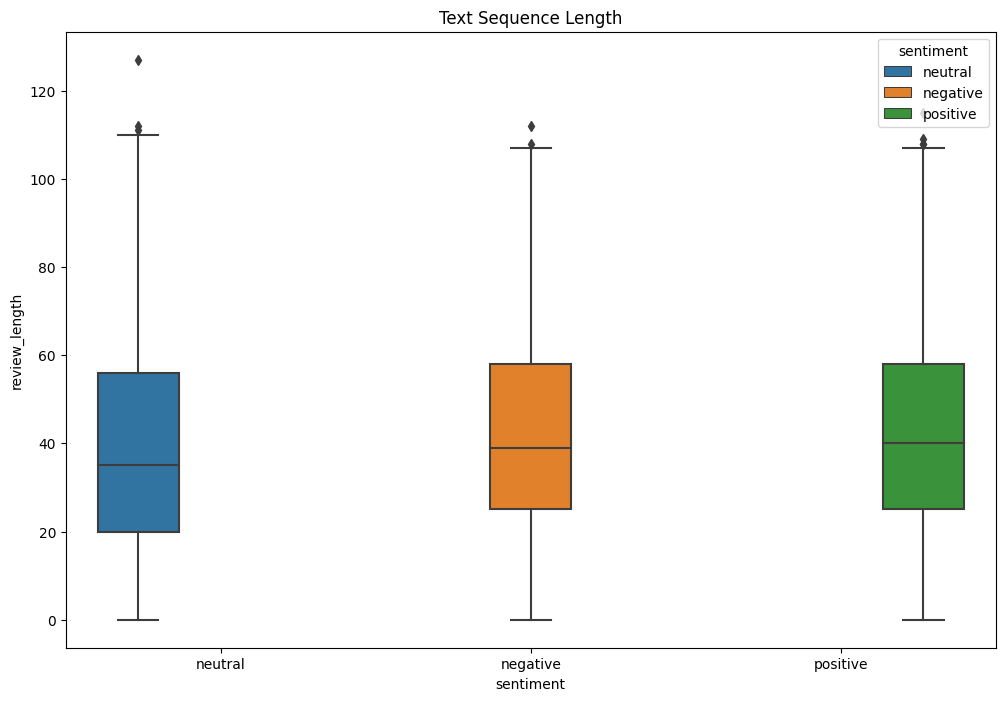

In [39]:
# Visualizing the average text sequence length
df2 = df.copy()
df2['review_length'] = 0
for i in tqdm(range(df.shape[0])):
    df2['review_length'][i] = len(df2['text'][i])

plt.figure(figsize=[12, 8])
sns.boxplot(x=target, y='review_length', data=df2, hue=target)
plt.title('Text Sequence Length')
plt.show()

In [40]:
# Word clouds for sentiments
neutraldata = original_df[original_df[target] == 'neutral']['text']
positivedata = original_df[original_df[target] == 'positive']['text']
negdata = original_df[original_df[target] == 'negative']['text']

In [41]:
def wordcloud_draw(data, color, s):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split() if (word != 'movie' and word != 'film')])
    wordcloud = WordCloud(
        stopwords=stopwords.words('english'),
        background_color=color,
        width=2500,
        height=2000
    ).generate(cleaned_word)
    plt.imshow(wordcloud)
    plt.title(s)
    plt.axis('off')

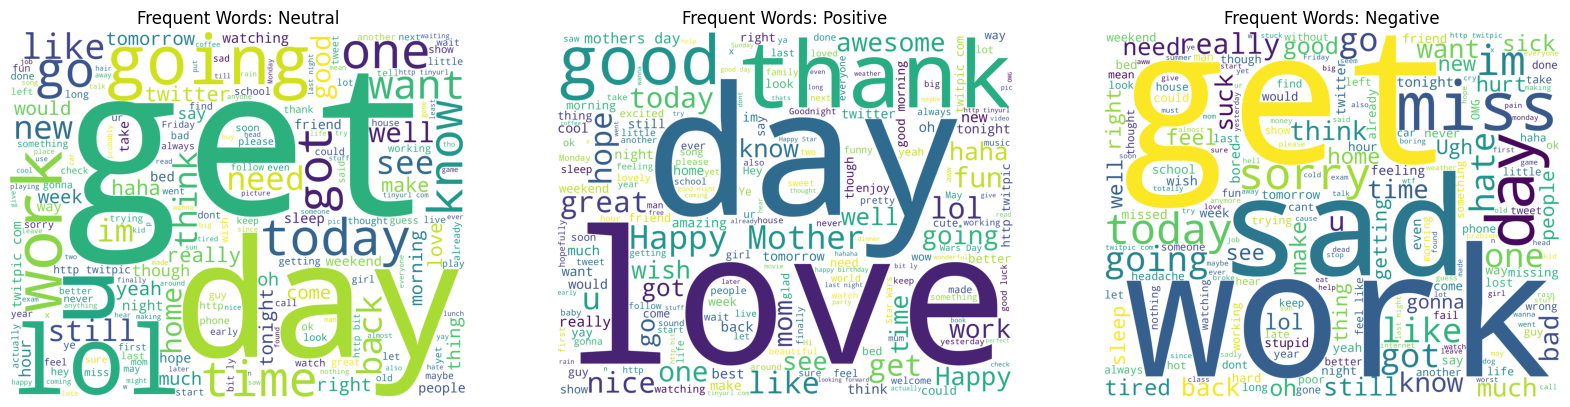

In [42]:
plt.figure(figsize=[20, 10])
plt.subplot(1, 3, 1)
wordcloud_draw(neutraldata, 'white', 'Frequent Words: Neutral')

plt.subplot(1, 3, 2)
wordcloud_draw(positivedata, 'white', 'Frequent Words: Positive')

plt.subplot(1, 3, 3)
wordcloud_draw(negdata, 'white', 'Frequent Words: Negative')
plt.show()

In [43]:
# Assigning labels to the target variable
MAP = {'negative': 0, 'neutral': 1, 'positive': 2}
df.sentiment = df.sentiment.map(MAP)

# Splitting the data into training & testing sets
X = x
Y = pd.Series(y).map(MAP)
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ', X.shape, len(Y), '\nTraining set  ---> ', Train_X.shape, len(Train_Y), '\nTesting set   ---> ',
      Test_X.shape, '', len(Test_Y))

Original set  --->  (27480, 22708) 27480 
Training set  --->  (21984, 22708) 21984 
Testing set   --->  (5496, 22708)  5496


In [44]:
# Evaluation Results DataFrame
Evaluation_Results = pd.DataFrame(np.zeros((4, 5)), columns=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC score'])
Evaluation_Results.index = ['Logistic Regression (LR)', 'Decision Tree Classifier (DT)', 'Random Forest Classifier (RF)',
                            'Naïve Bayes Classifier (NB)']

In [45]:
# Function to summarize classification results
def Classification_Summary(pred, pred_prob, i):
    Evaluation_Results.iloc[i]['Accuracy'] = round(accuracy_score(Test_Y, pred), 3) * 100
    Evaluation_Results.iloc[i]['Precision'] = round(precision_score(Test_Y, pred, average='weighted'), 3) * 100


In [46]:
classifiers = {
    'Logistic Regression (LR)': LogisticRegression(),
    'Decision Tree Classifier (DT)': DecisionTreeClassifier(),
    'Random Forest Classifier (RF)': RandomForestClassifier(),
    'Naïve Bayes Classifier (NB)': BernoulliNB(),
}

In [47]:
# Model Training and Evaluation
for i, (clf_name, clf) in enumerate(classifiers.items()):
    print(f'\nTraining {clf_name}...')

    # Training the classifier
    clf.fit(Train_X, Train_Y)

    # Predicting on the test set
    pred = clf.predict(Test_X)
    pred_prob = clf.predict_proba(Test_X)

    # Display classification report
    print(f'\nClassification Report for {clf_name}:\n')
    print(classification_report(Test_Y, pred))

    # Summarize classification results
    Classification_Summary(pred, pred_prob, i)


Training Logistic Regression (LR)...

Classification Report for Logistic Regression (LR):

              precision    recall  f1-score   support

           0       0.72      0.57      0.63      1523
           1       0.62      0.76      0.68      2275
           2       0.76      0.68      0.72      1698

    accuracy                           0.68      5496
   macro avg       0.70      0.67      0.68      5496
weighted avg       0.69      0.68      0.68      5496


Training Decision Tree Classifier (DT)...

Classification Report for Decision Tree Classifier (DT):

              precision    recall  f1-score   support

           0       0.60      0.59      0.60      1523
           1       0.63      0.62      0.63      2275
           2       0.69      0.71      0.70      1698

    accuracy                           0.64      5496
   macro avg       0.64      0.64      0.64      5496
weighted avg       0.64      0.64      0.64      5496


Training Random Forest Classifier (RF)...



In [48]:
# Display Evaluation Results
print("\nEvaluation Results:")
print(Evaluation_Results)


Evaluation Results:
                               Accuracy  Precision  Recall  F1-score  \
Logistic Regression (LR)           68.2       69.2     0.0       0.0   
Decision Tree Classifier (DT)      64.1       64.1     0.0       0.0   
Random Forest Classifier (RF)      69.4       69.8     0.0       0.0   
Naïve Bayes Classifier (NB)        63.5       66.1     0.0       0.0   

                               AUC-ROC score  
Logistic Regression (LR)                 0.0  
Decision Tree Classifier (DT)            0.0  
Random Forest Classifier (RF)            0.0  
Naïve Bayes Classifier (NB)              0.0  
